In [376]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import LogFormatterSciNotation
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages
import glob
%matplotlib inline

In [465]:
def get_marker(method):
    if method == "manual":
        return "x"
    elif method == "mpi_ddt":
        return "+"
    elif method == "mpi_pack_ddt":
        return "o"
    elif method == "reference":
        return "^"
    elif method == "custom":
        return "v"
    elif method == "mpicd_reference":
        return "s"
    elif method == "mpicd_manual":
        return "d"
    elif method == "custom_region":
        return "<"


def get_color(method):
    if method == "manual":
        return "green"
    elif method == "mpi_ddt":
        return "purple"
    elif method == "mpi_pack_ddt":
        return "magenta"
    elif method == "reference":
        return "gray"
    elif method == "custom":
        return "red"
    elif method == "mpicd_reference":
        return "gray"
    elif method == "mpicd_manual":
        return "blue"
    elif method == "custom_region":
        return "orange"

def get_linestyle(method):
    if method == "manual":
        return ":"
    elif method == "mpi_ddt":
        return ":"
    elif method == "mpi_pack_ddt":
        return ":"
    elif method == "reference":
        return ":"
    elif method == "custom":
        return "-"
    elif method == "mpicd_reference":
        return "-"
    elif method == "mpicd_manual":
        return "-"
    elif method == "custom_region":
        return "-"

def get_label(method):
    if method == "manual":
        return "OMPI Manual"
    elif method == "mpi_ddt":
        return "OMPI DDT"
    elif method == "mpi_pack_ddt":
        return "OMPI Pack DDT"
    elif method == "reference":
        return "OMPI Ref"
    elif method == "custom":
        return "MPICD Pack"
    elif method == "mpicd_reference":
        return "MPICD Ref"
    elif method == "mpicd_manual":
        return "MPICD Manual"
    elif method == "custom_region":
        return "MPICD Regions"


def filter(testname):
    if testname == "LAMMPS_atomic": return True
    if "FFT" in testname: return True
    if "WRF" in testname and "_sa" in testname: return True
    if "SPECFEM" in testname: return True
    return False

def fix_name(method):
    if method == "custom_reference": return "mpicd_reference"
    else: return method

In [466]:
def load_bench_files(pathname):
    files = glob.glob(pathname)
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep='\\s+', header=0, #comment='F',
                         usecols=[0, 1, 2, 3, 4],
                         #names=['testname', 'method', 'bytes', 'id', 'time'],
                         )
        dfs.append(df)

    dfraw = pd.concat(dfs)
    dfs.clear()
    return dfraw



In [467]:
def compute_mean_std(dfraw):
    """compute mean and std"""
    tests = []
    impls = []
    sizes = []
    avgs  = []
    stds  = []
    for name, v in dfraw.groupby(["testname", "method", "bytes"]):
        bench = name[0]
        if filter(bench): continue
        impl = fix_name(name[1])
        size = int(name[2])
        sum = []
        #print("%s v[id] %s: %s"%(impl, v["id"].unique(), 'pack' in v["id"].unique()))
        if 'pack' in v["id"].unique() and len(v[ (v.id == "pack") ]["time"]) > 1:
            '''
            Packed types: total time = pack + comm + unpack
            '''
            #if len( v[ (v.id == "pack") ]["time"] ) != len(v[ (v.id == "unpack") ]["time"]) or len(v[ (v.id == "unpack") ]["time"]) != len(v[ (v.id == "communication") ]["time"]):
            #    print("Mismatch: %s %s %s"%(len( v[ (v.id == "pack") ]["time"] ), len(v[ (v.id == "unpack") ]["time"]), len(v[ (v.id == "communication") ]["time"])))
            #print("adding pack/unpack for %s"%(impl))
            sum = v[ (v.id == "pack") ]["time"].to_numpy() + v[ (v.id == "unpack") ]["time"].to_numpy() + v[ (v.id == "communication") ]["time"].to_numpy()
            #print(sum)
            #print(v[ (v.id == "pack") ]["time"])
            #print(v[ (v.id == "unpack") ]["time"])
            #print(v[ (v.id == "communication") ]["time"])
        else:
            sum = v[ (v.id == "communication") ]["time"].to_numpy()
        avg = np.mean(sum[1:-1])
        std = np.std(sum[1:-1])
        tests.append(bench)
        impls.append(impl)
        sizes.append(size)
        avgs.append(avg)
        stds.append(std)

    return pd.DataFrame(data={'testname': tests, 'method': impls, 'bytes': sizes, 'time_avg': avgs, 'time_std': stds})


In [476]:
def plot_horizontal(dfall, filename, fn, ylabel, logscale):
    pp = PdfPages(filename)
    benchmarks = dfall.testname.unique()
    fig = plt.figure(figsize=(16, 4))
    axs = fig.subplots(1, len(benchmarks))
    i = 0
    maxy = 0
    for bench in dfall.testname.unique():

        df = dfall[ dfall.testname == bench ]
        for name, v in df.groupby(["method"], sort=True):
            method = name[0]
            xvals, yvals, yerrs = fn(v)
            #xvals = v['bytes'] / 1E3
            #yvals = xvals / 1E3 / (v['time_avg'] / 1E6)

            #ax.errorbar(xvals, yvals, yerrs, label="%s"%(method))
            axs[i].errorbar(xvals, yvals, yerrs,
                            label=get_label(method),
                            marker=get_marker(method),
                            color=get_color(method),
                            linestyle=get_linestyle(method),
                            linewidth=.8,
                            capsize=2)
            maxy = np.max([np.max(yvals), maxy])

        #ax.set_title("Barrier skew (%s %s per node)"%(npn, "processes" if (npn > 1) else "process"))
        #axs[i].set_xlabel("Size [kB]")
        #axs[i].set_ylabel("Bandwidth [MB/s]")
        axs[i].set_title(bench)
        axs[i].legend(prop={'size': 6})
        axs[i].grid(which="both")
        axs[i].set_xscale('log')
        #axs[i].set_xticks(xvals, labels=[str(math.ceil(x)) for x in xvals])
        axs[i].set_xlim(left=np.min(xvals)*0.8, right=np.max(xvals)*1.2)
        axs[i].xaxis.set_major_formatter(LogFormatterSciNotation())
        axs[i].xaxis.set_minor_formatter(NullFormatter())
        #axs[i].ticklabel_format(useOffset=False, style='plain')
        #axs[i].set_xlim(left=10**(math.floor(math.log10(np.min(xvals)))),
        #                right=10**(math.ceil(math.log10(np.max(xvals)))))
        i = i+1

    for ax in axs.flat:
        ax.set(xlabel="Size [kB]", ylabel=ylabel)
        if (logscale):
            ax.set_yscale('log')
            ax.set_ylim(bottom=1, top=maxy*1.1)
        else:
            ax.set_ylim(bottom=0, top=maxy*1.1)
        #ax.tick_params(axis='x', rotation=45)
        #ax.tick_params(axis='x', labelrotation=45)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    pp.savefig(fig)
    pp.close()



In [477]:
def bandwidth_fn(v):
    xvals = v['bytes'] / 1E3
    yvals = xvals / 1E3 / (v['time_avg'] / 1E6)
    yerrs = [0 for x in xvals] # no errors
    return [xvals, yvals, yerrs]

def time_fn(v):
    xvals = v['bytes'] / 1E3
    yvals = v['time_avg']
    yerrs = v['time_std']
    return [xvals, yvals, yerrs]

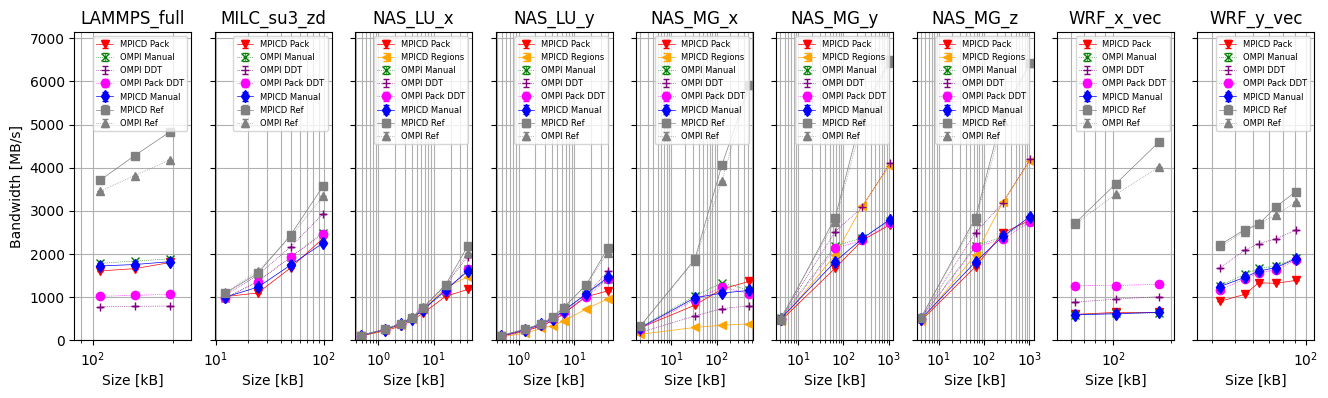

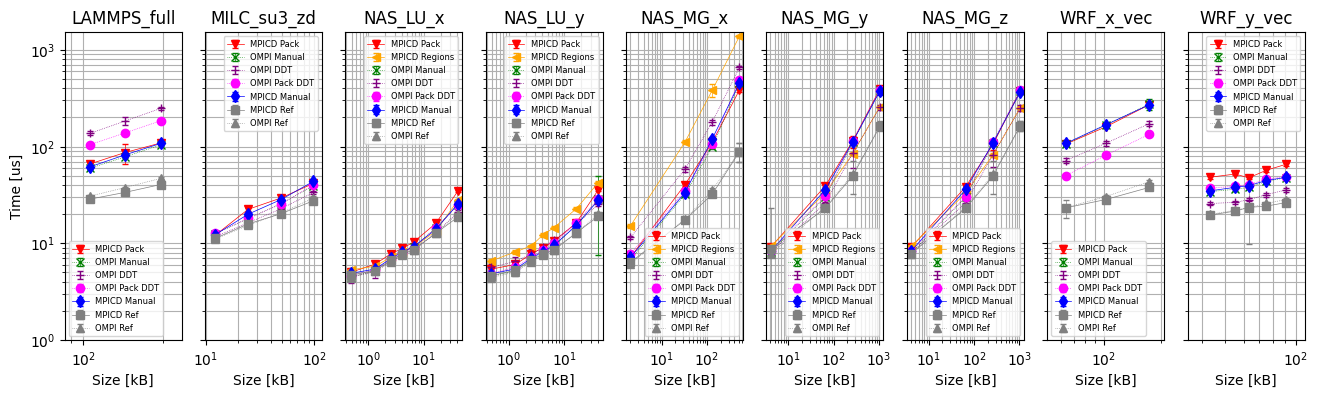

In [478]:
dfraw = load_bench_files('../../../results/ddtbench-2024-07-11-two-node/ddtbench*.out')
dfall = compute_mean_std(dfraw)
#print(dfraw.to_string())
#print(dfall.to_string())
plot_horizontal(dfall, filename="ddtbench-one-node_bw.pdf", fn=bandwidth_fn, ylabel="Bandwidth [MB/s]", logscale=False)
plot_horizontal(dfall, filename="ddtbench-one-node_time.pdf", fn=time_fn, ylabel="Time [us]", logscale=True)

In [479]:
dfraw = load_bench_files('extra_progress/ddtbench*_shm.out')
dfall = compute_mean_std(dfraw)
plot_horizontal(dfall, filename="ddtbench-two-node.pdf")

TypeError: plot_horizontal() missing 3 required positional arguments: 'fn', 'ylabel', and 'logscale'

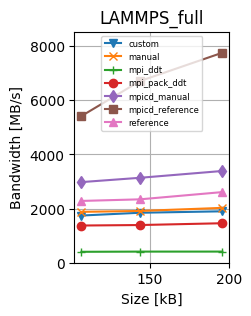

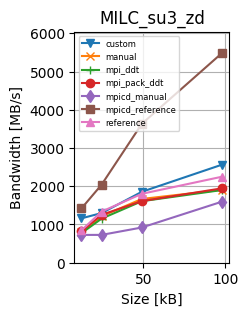

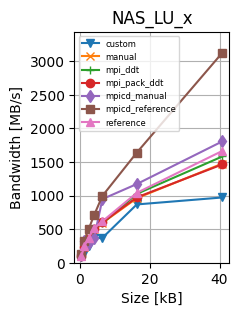

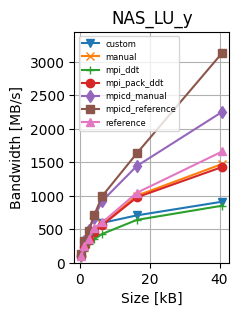

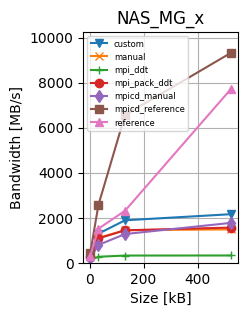

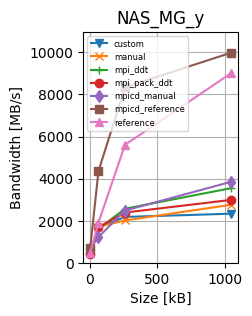

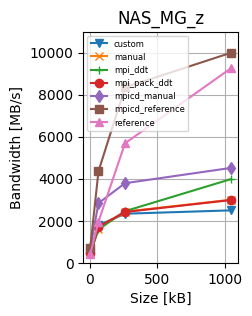

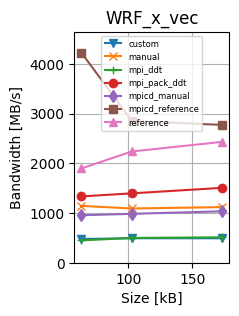

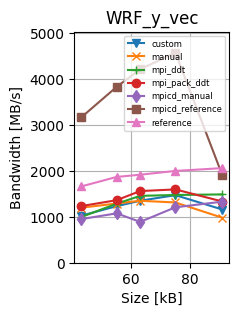

In [ ]:

filename = "ddtbench.pdf"
pp = PdfPages(filename)
for bench in dfall.testname.unique():
    fig = plt.figure(figsize=(2, 3))
    ax=plt.subplot()

    df = dfall[ dfall.testname == bench ]
    maxy = 0
    for name, v in df.groupby(["method"]):
        method = name[0]
        xvals = v['bytes'] / 1E3
        yvals = xvals / 1E3 / (v['time_avg'] / 1E6)
        yerrs = xvals / 1E3 / (v['time_std'] / 1E6)

        #ax.errorbar(xvals, yvals, yerrs, label="%s"%(method))
        ax.plot(xvals, yvals, label="%s"%(method), marker=get_marker(method))
        maxy = np.max([np.max(yvals), maxy])

    #ax.set_title("Barrier skew (%s %s per node)"%(npn, "processes" if (npn > 1) else "process"))
    ax.set_xlabel("Size [kB]")
    ax.set_ylabel("Bandwidth [MB/s]")
    ax.set_title(bench)
    ax.legend(prop={'size': 6})
    ax.set_ylim(bottom=0, top=maxy*1.1)
    ax.grid()
    #ax.plot()
    #fig.tight_layout()
    pp.savefig(fig)
    #plt.close(fig)

pp.close()